# LSTM Training
This notebook can be used to train an LSTM for text classification and generate predictions for the kaggle competition found [here](https://www.kaggle.com/c/quora-insincere-questions-classification). 

The notebook utilizes Keras and GloVe for preprocessing using word embeddings. Then, Keras with Tensorflow backend is used for training a deep LSTM. Feel free to fork!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Embedding, CuDNNLSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.models import Model

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# Load in training and testing data
train_df = pd.read_csv('./input/train.csv')
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


# 1. EDA
The following code will perform basic EDA to gain an understanding of the dataset and perhaps inspire the design of the neural network.

Note: Section 1 is not required for the rest of the notebook and may be skipped if desired. 

## 1.1 Sentiment Analysis
This subsection analyzes each question using the NLTK sentiment analyzer. The goal is to determine whether the sincere and insincere questions have a significant difference in sentiment. 

Note: The sentiment analyis takes about 3 minutes to run on my machine. Tips are welcome on how to increase the speed of this operation!

In [3]:
# Sentiment analysis requires the nltk package
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer and define the sentiment extraction function
sid = SentimentIntensityAnalyzer()
def extract_sentiment(text):
    scores = sid.polarity_scores(text)
    return scores['compound']

train_df['sent'] = train_df['question_text'].apply(lambda x: extract_sentiment(x))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/bmmidei/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
print('The average sentiment score for sincere questions is {:0.4f}'.\
          format(np.mean(train_df[train_df['target']==0]['sent'])))
print('The average sentiment score for insincere questions is {:0.4f}'. \
          format(np.mean(train_df[train_df['target']==1]['sent'])))

The average sentiment score for sincere questions is 0.0835
The average sentiment score for insincere questions is -0.0998


From the density plot below, we can see that a large number of questions are classified as exactly neutral, with a sentiment score of 0.0. It would appear that there is no strong significant difference in sentiment between sincere and insincere questions

Text(0, 0.5, 'Density')

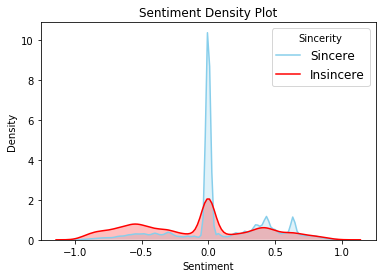

In [6]:
sent_sinc = train_df[train_df['target']==0]['sent'].values
sent_insinc = train_df[train_df['target']==1]['sent'].values

sns.kdeplot(sent_sinc, shade=1, color="skyblue", label="Sincere")
sns.kdeplot(sent_insinc, shade=1, color="red", label="Insincere")

# Plot formatting
plt.legend(prop={'size': 12}, title = 'Sincerity')
plt.title('Sentiment Density Plot')
plt.xlabel('Sentiment')
plt.ylabel('Density')

## 1.2 Word Count
This code will analyze word count characteristics of the dataset and determine whether there is a distinction in word count between the sincere and insincere questions. 

In [7]:
train_df['word_count'] = train_df['question_text'].apply(lambda x: len(x.split()))

In [10]:
print('The average word length of sincere questions in the training set is {0:.1f}.'\
          .format(np.mean(train_df[train_df['target']==0]['word_count'])))
print('The average word length of insincere questions in the training set is {0:.1f}.' \
          .format(np.mean(train_df[train_df['target']==1]['word_count'])))
print('The maximum word length for a question in the training set is {0:.0f}.'\
          .format(np.max(train_df['word_count'])))

The average word length of sincere questions in the training set is 12.5.
The average word length of insincere questions in the training set is 17.3.
The maximum word length for a question in the training set is 134.


From the plot below, we can see that the word count distribution for sincere questions has a much sharper peak. It appears that insincere questions tend to be a bit longer than sincere questions. 

Text(0, 0.5, 'Density')

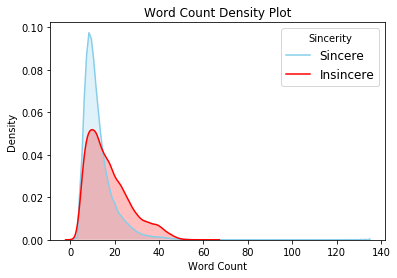

In [11]:
wc_sinc = train_df[train_df['target']==0]['word_count'].values
wc_insinc = train_df[train_df['target']==1]['word_count'].values

sns.kdeplot(wc_sinc, shade=1, color="skyblue", label="Sincere")
sns.kdeplot(wc_insinc, shade=1, color="red", label="Insincere")

# Plot formatting
plt.legend(prop={'size': 12}, title = 'Sincerity')
plt.title('Word Count Density Plot')
plt.xlabel('Word Count')
plt.ylabel('Density')

## 1.3 Word Cloud
Because word clouds look cool

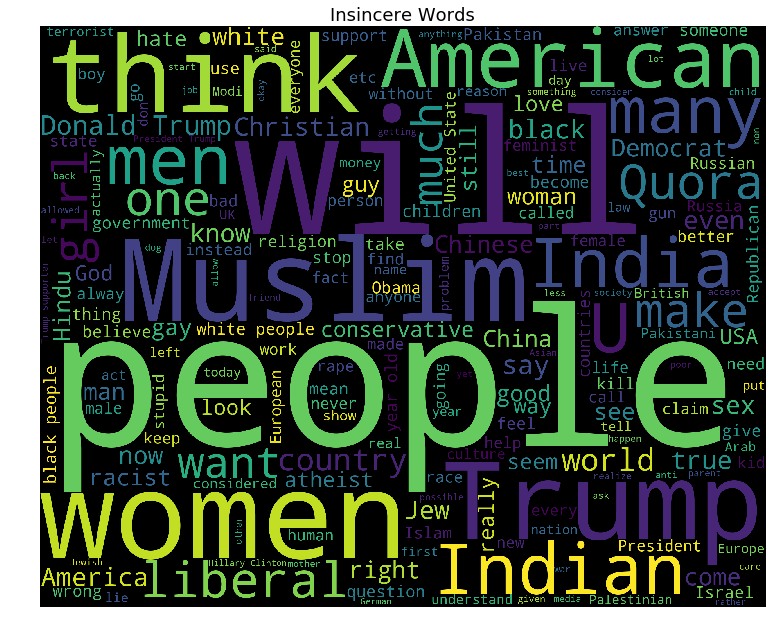

In [17]:
from wordcloud import WordCloud,STOPWORDS

def wordcloud_draw(data, title, color='black'):
    words = ' '.join(data)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(words)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.title(title, fontdict={'fontsize':18})
    plt.axis('off')
    plt.show()

title = "Sincere words"
wordcloud_draw(train_df[train_df['target']==0]['question_text'], title, 'white')
title = "Insincere Words"
wordcloud_draw(train_df[train_df['target']==1]['question_text'], title, 'black')

#2 Data Preparation
This section of the notebook is devoted to preprocessing the raw data into a form that the neural network can understand.

In [ ]:
# Extract the training data and corresponding labels
text = train_df['question_text'].fillna('unk').values
labels = train_df['target'].values

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(text, labels,\
                                                  test_size=0.2)

In [ ]:
embed_size = 300 # Size of each word vector
max_words = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

In [ ]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

word_index = tokenizer.word_index
print('The word index consists of {} unique tokens.'.format(len(word_index)))

## Pad the sentences 
X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)

In [ ]:
# Create the embedding dictionary from the word embedding file
embedding_dict = {}
filename = os.path.join('../input/embeddings/', 'glove.840B.300d/glove.840B.300d.txt')
with open(filename) as f:
    for line in f:
        line = line.split()
        token = line[0]
        try:
            coefs = np.asarray(line[1:], dtype='float32')
            embedding_dict[token] = coefs
        except:
            pass
print('The embedding dictionary has {} items'.format(len(embedding_dict)))

In [ ]:
# Create the embedding layer weight matrix
embed_mat = np.zeros(shape=[max_words, embed_size])
for word, idx in word_index.items():
    # Word index is ordered from most frequent to least frequent
    # Ignore words that occur less frequently
    if idx >= max_words: continue
    vector = embedding_dict.get(word)
    if vector is not None:
        embed_mat[idx] = vector

# 3. Neural Network Training

In [ ]:
def create_lstm():
    input = Input(shape=(maxlen,))
    
    # Embedding layer has fixed weights, so set 'trainable' to False
    x = Embedding(max_words, embed_size, weights=[embed_mat], trainable=False)(input)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=input, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

In [ ]:
# Create and train network
lstm = create_lstm()
lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=512)

# 4. Predictions
The remainder of this notebok will generate predictions from the test set and write them to a submission csv file for the kaggle competition.

In [ ]:
test_df = pd.read_csv('../input/test.csv')
X_test = test_df['question_text'].values

# Perform the same preprocessing as was done on the training set
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen)

# Make predictions, ensure that predictions are in integer form
preds = np.rint(lstm.predict([X_test], batch_size=1024, verbose=1)).astype('int')
test_df['prediction'] = preds

Let's examine a few examples of sincere predictions and insincere predictions. It appears that our network is making meaningful predictions

In [ ]:
sin_sample = test_df.loc[test_df['prediction'] == 0]['question_text'].head()
print(sin_sample)
insin_sample = test_df.loc[test_df['prediction'] == 1]['question_text'].head()
print(insin_sample)

In [ ]:
test_df = test_df.drop('question_text', axis=1)
test_df.to_csv('submission.csv', index=False)